In [1]:
from train import resnet_classification

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from classification_dataload import ClassificationDataset
from matplotlib import pyplot as plt
import util
import numpy
from collections import Counter

import importlib
from sklearn import metrics
rl = importlib.reload

In [2]:
target_category='order_class'
model_ft, hist = resnet_classification(loading_model=True, model_name='resnet101_order_class_300_newdata', target_category = target_category)

Loading customized pre-trained model


In [3]:
model_ft.eval()
image_root = 'image'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_datasets = {x: ClassificationDataset(set_name=x, root_dir=image_root, target_category=target_category, flip_image=False)
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                          shuffle=False, num_workers=6)
           for x in ['train', 'val', 'test']}

In [4]:
val_data = dataloaders['val']
train_data = dataloaders['train']
test_data = dataloaders['test']

dataset = val_data

In [5]:
classes = dataset.dataset.classes
maps = dataset.dataset.species_classes_map

In [6]:
classes

['Ghost',
 'Aves',
 'Cingulata',
 'Didelphimorphia',
 'Mammalia',
 'Reptilia',
 'Rodentia']

In [7]:
maps

{'Ghost': 0,
 'Aves': 1,
 'Cingulata': 2,
 'Didelphimorphia': 3,
 'Mammalia': 4,
 'Reptilia': 5,
 'Rodentia': 6}

In [8]:
len(dataset.dataset)

188

In [9]:
Counter(train_data.dataset.data_set_species)

Counter({'Rodentia': 240,
         'Didelphimorphia': 138,
         'Ghost': 667,
         'Mammalia': 66,
         'Aves': 286,
         'Cingulata': 59,
         'Reptilia': 22})

In [10]:
Counter(val_data.dataset.data_set_species)

Counter({'Rodentia': 33,
         'Didelphimorphia': 20,
         'Ghost': 80,
         'Aves': 36,
         'Reptilia': 4,
         'Cingulata': 7,
         'Mammalia': 8})

In [11]:
Counter(test_data.dataset.data_set_species)

Counter({'Rodentia': 31,
         'Ghost': 83,
         'Mammalia': 7,
         'Aves': 35,
         'Didelphimorphia': 19,
         'Reptilia': 4,
         'Cingulata': 7})

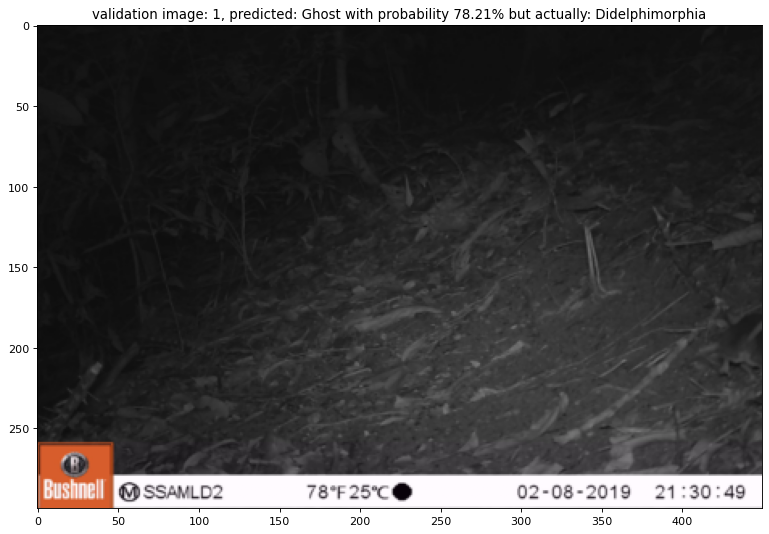

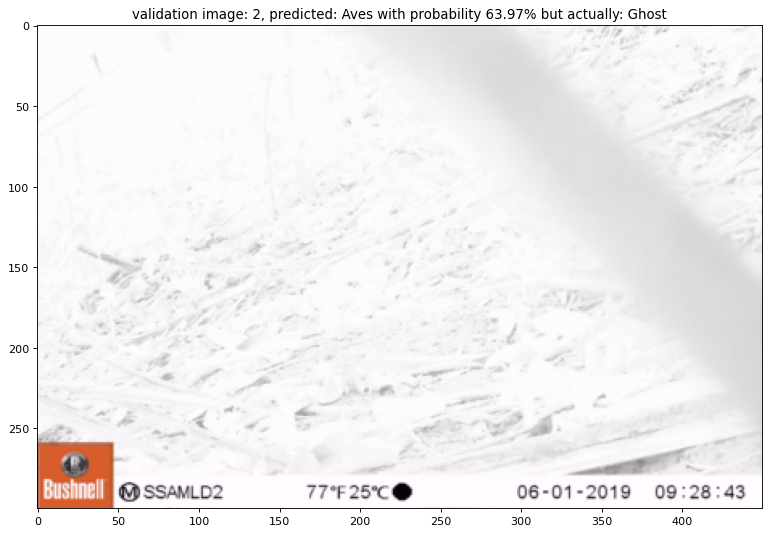

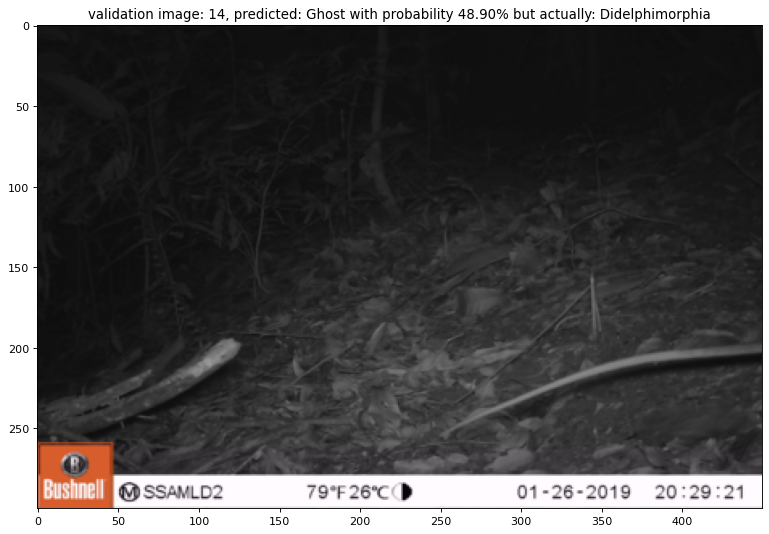

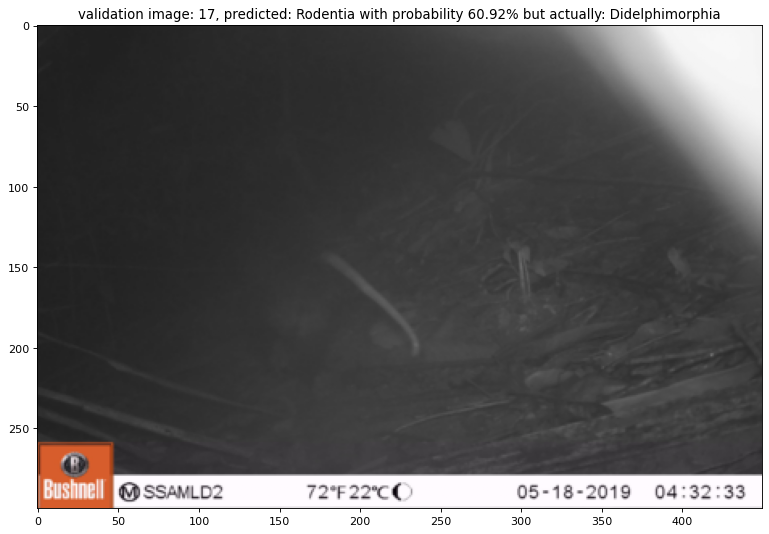

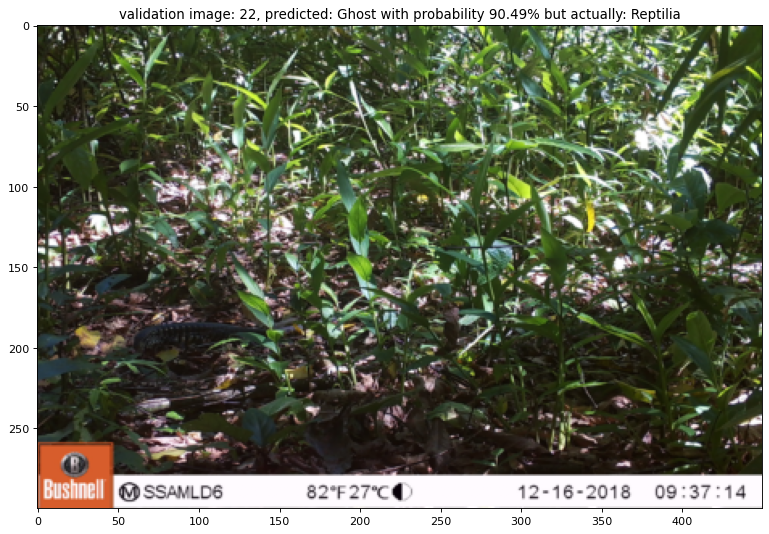

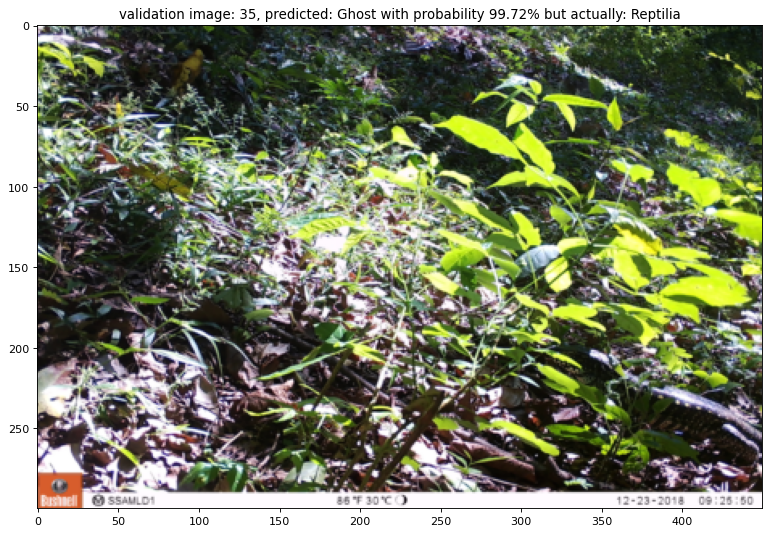

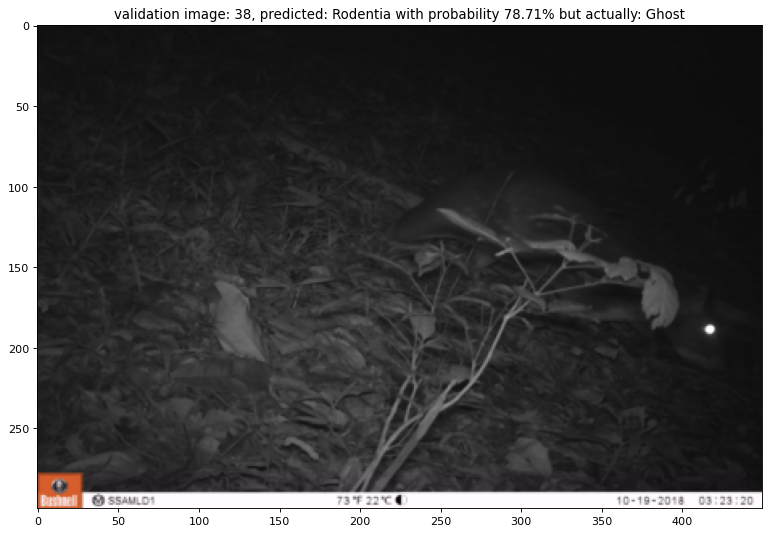

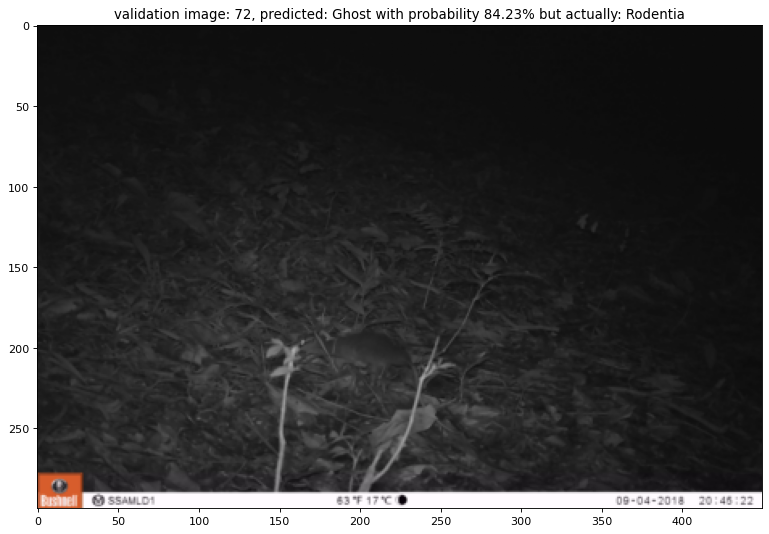

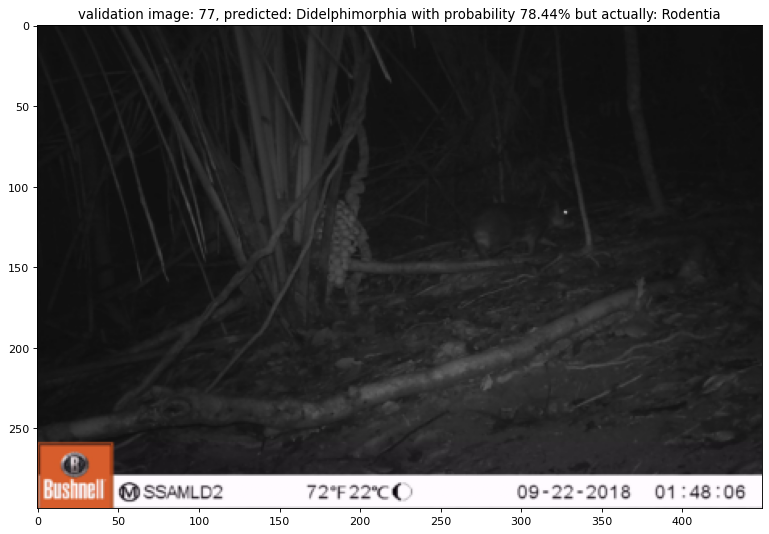

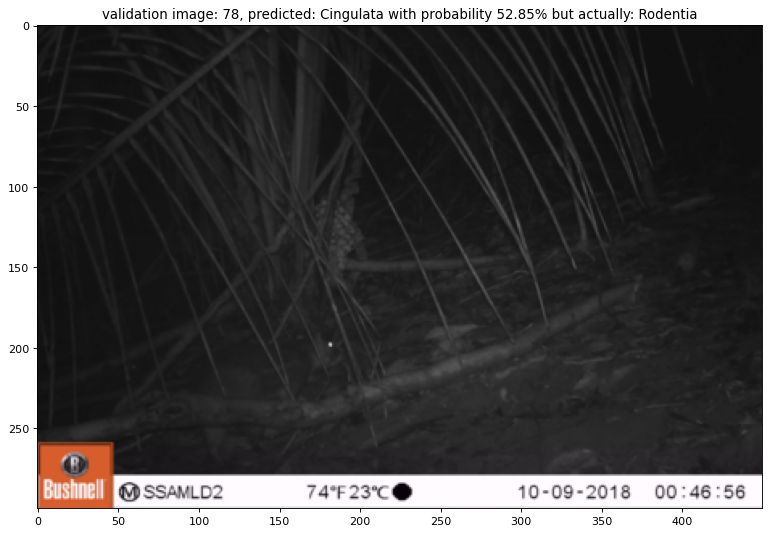

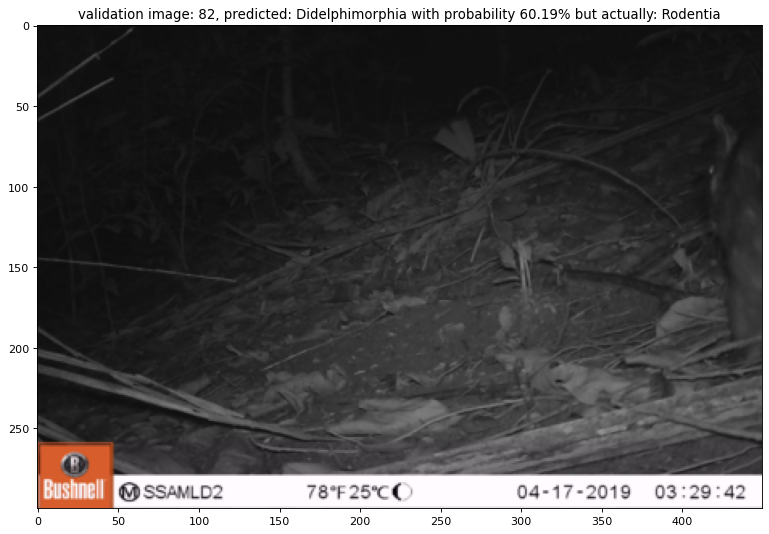

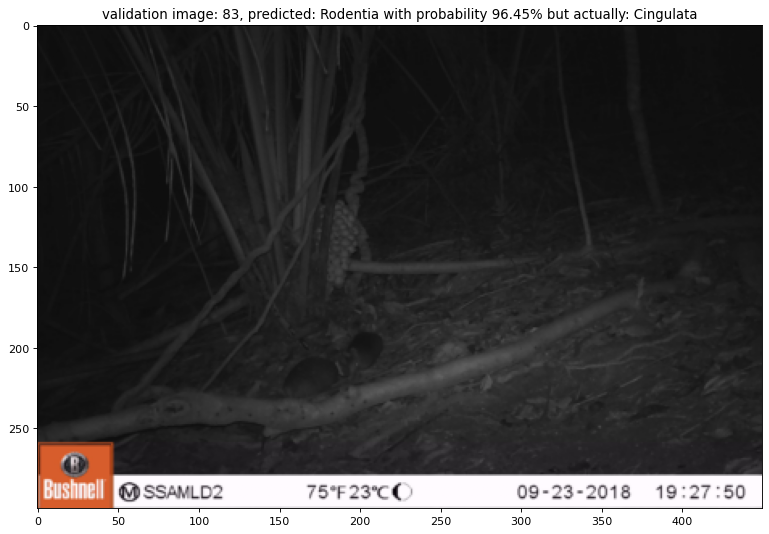

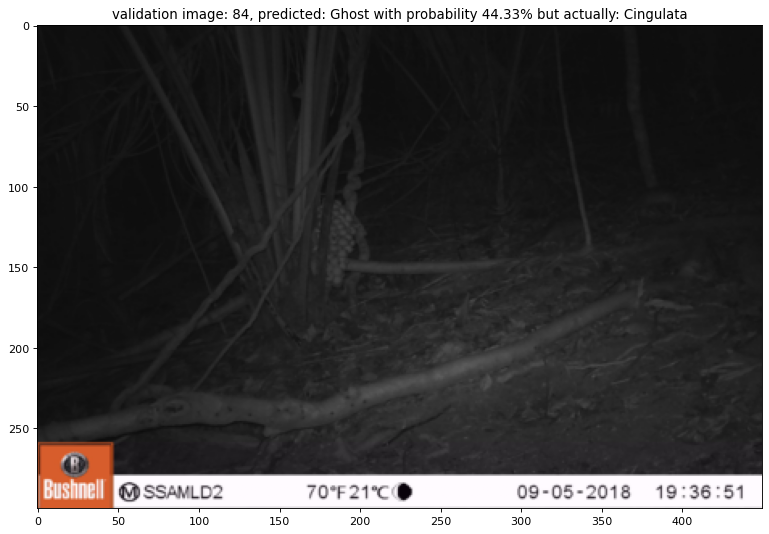

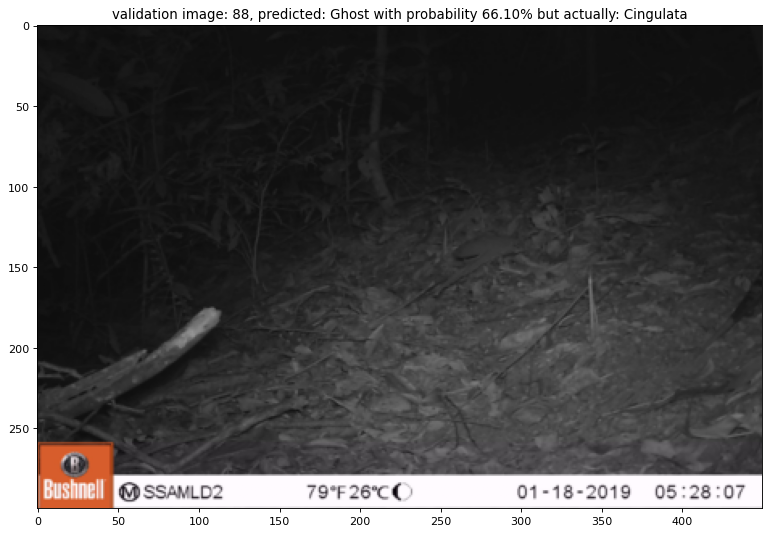

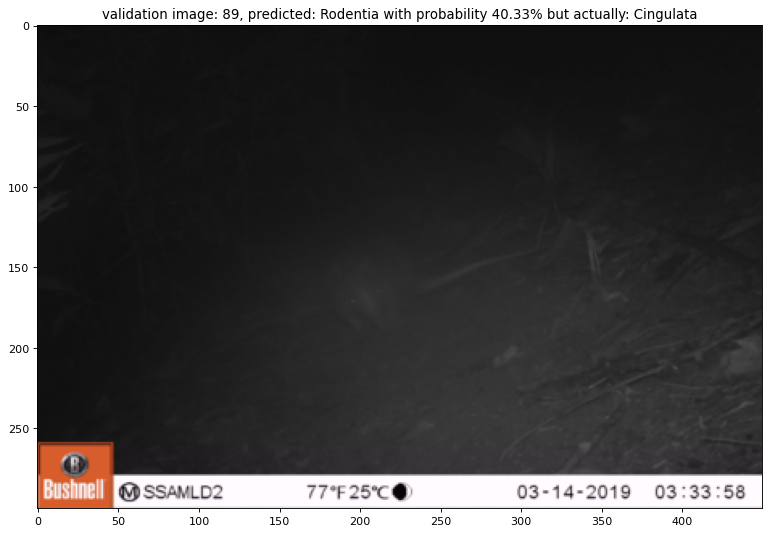

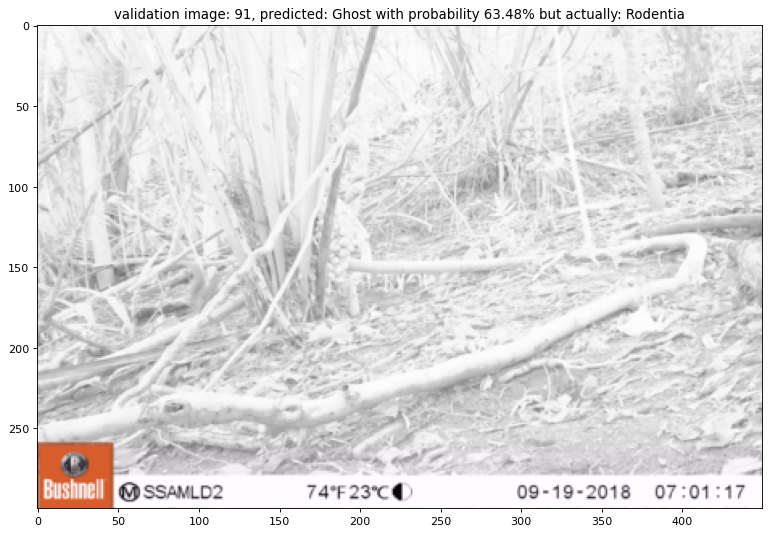

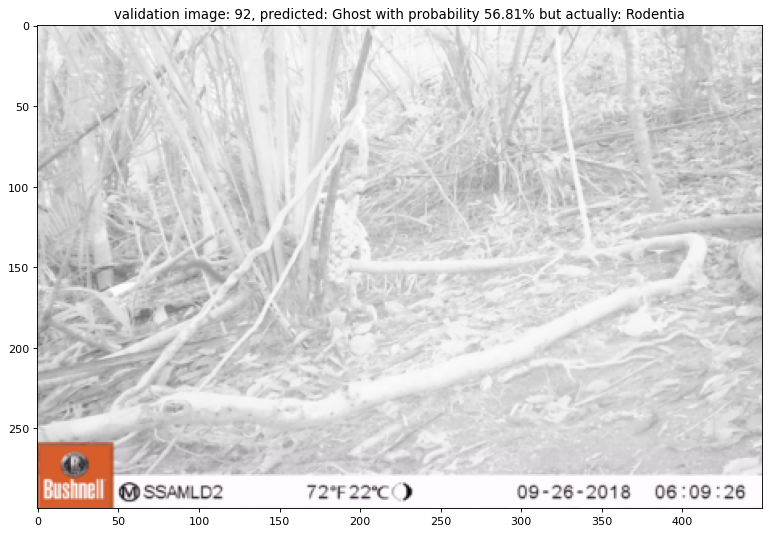

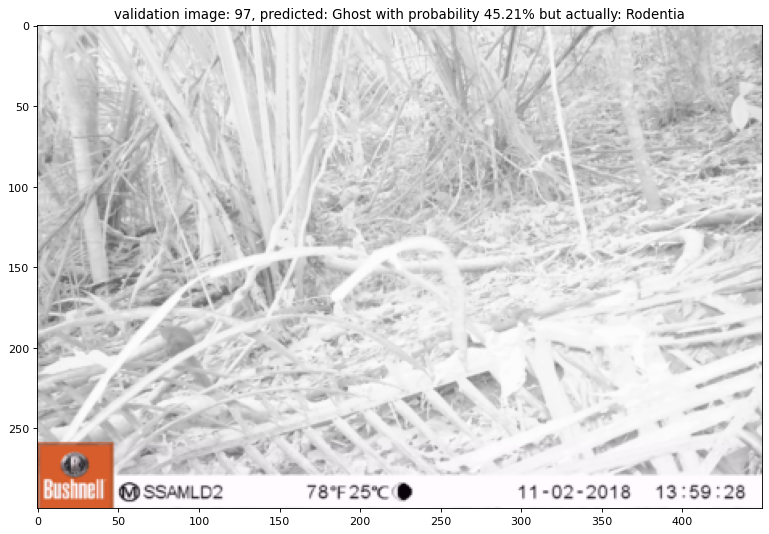

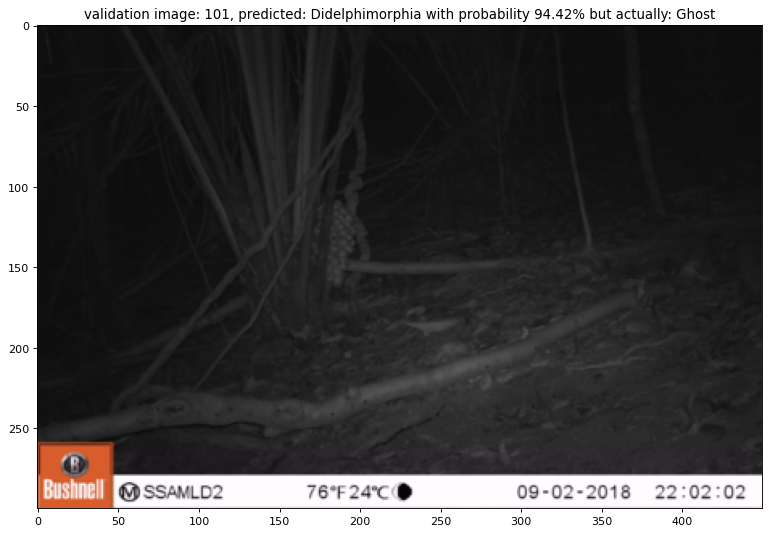

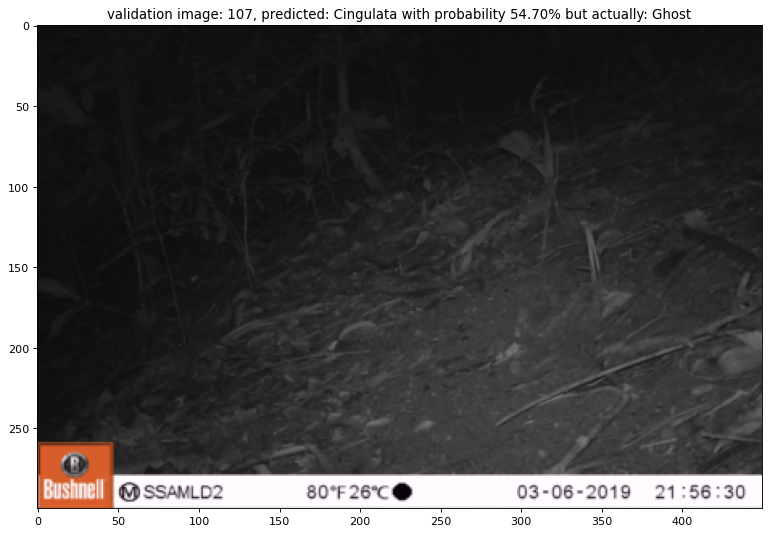

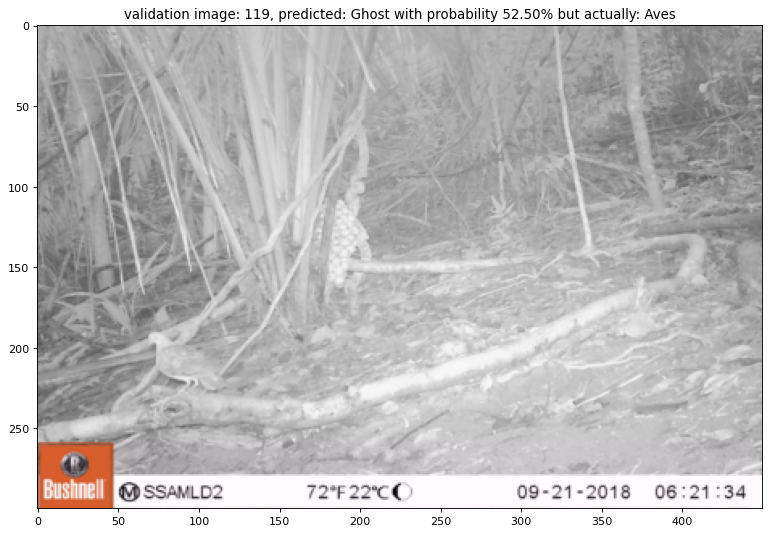

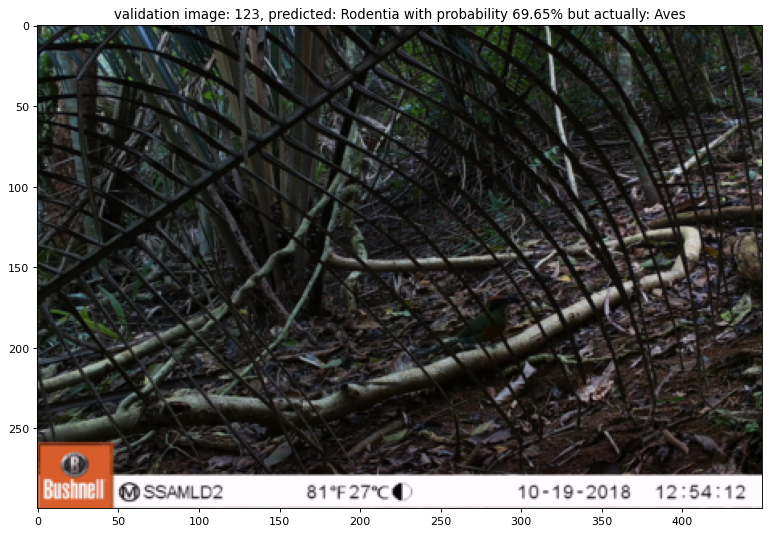

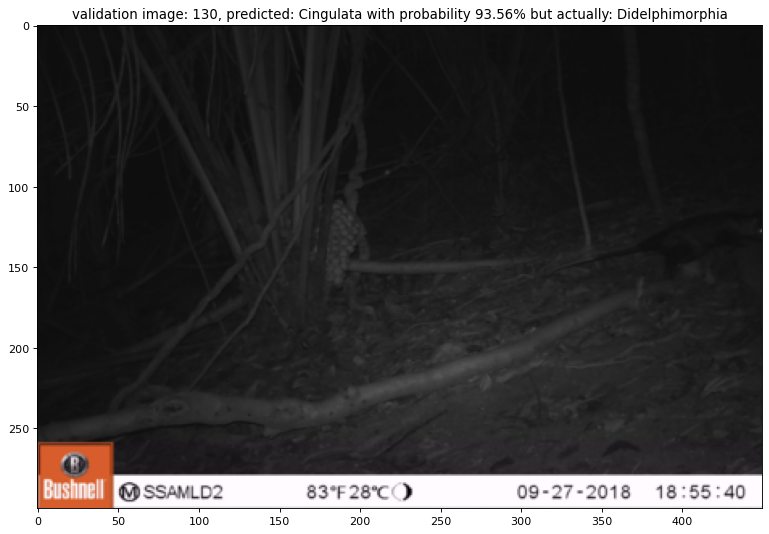

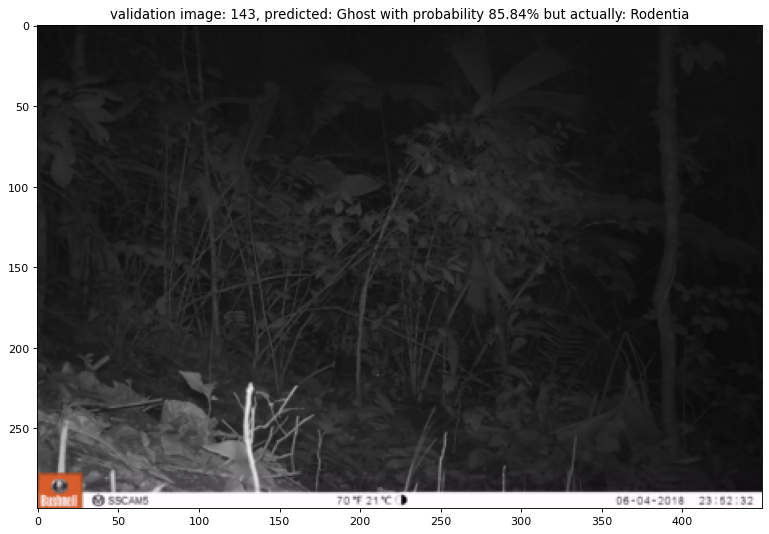

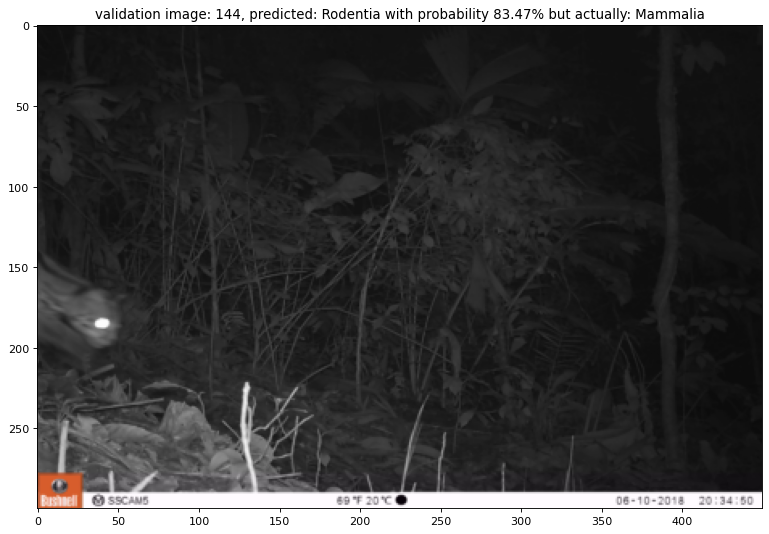

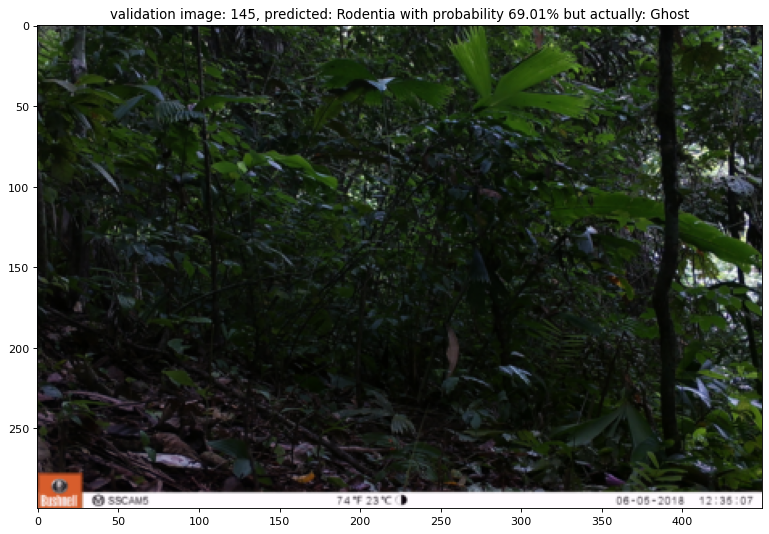

In [12]:
pred_list = []
actual_list = []
probablity_list = []
softmax = torch.nn.Softmax(dim=1)
misclassified_index = []

cam_trap = numpy.array(dataset.dataset.cam_trap)

with torch.no_grad():
    for image_index, (inputs, labels) in enumerate(dataset):
        inputs = inputs.to(device)
        labels = labels.to(device)    
        actual_list += labels.tolist()

        outputs = model_ft(inputs)
        prob = softmax(outputs).tolist()
        probablity_list += prob
        
        _, preds = torch.max(outputs, 1)
        pred_list += preds.tolist()
        
        if any(preds != labels):
            misclassified_index += [image_index]
            util.imshow(inputs[preds != labels, :, :, :].cpu(), 
                        title=['validation image: {}, predicted: {} with probability {:.2f}% but actually: {}'.format(image_index, classes[int(preds[i])], max(prob[0])*100,classes[int(labels[i])]) 
                               for i in range(len(preds)) if labels[i] !=preds[i]],
                       savefig='savefig/validation_image_{}_camptrap_{}.png'.format(image_index, cam_trap[image_index]))

In [13]:
Counter(numpy.array(dataset.dataset.cam_trap)[misclassified_index])

Counter({'SSAMLD2_2': 4, 'CT06': 1, 'CT01': 3, 'SSAMLD2': 15, 'SS CAM5': 3})

In [14]:
Counter(numpy.array(dataset.dataset.cam_trap))

Counter({'SSAMLD2_2': 19,
         'CT08': 2,
         'CT06': 6,
         'CT01': 46,
         'CT07': 1,
         'SSAMLD2': 58,
         'CT04': 7,
         'CT03': 1,
         'SS CAM4': 2,
         'SS CAM3': 1,
         'SS CAM5': 3,
         'SS CAM19': 8,
         'SS CAM7': 3,
         'SS CAM6': 2,
         'SS CAM1': 21,
         'SS CAM8': 8})

In [15]:
sum(numpy.array(pred_list) != numpy.array(actual_list))

26

In [16]:
Counter(dataset.dataset.data_set_species)

Counter({'Rodentia': 33,
         'Didelphimorphia': 20,
         'Ghost': 80,
         'Aves': 36,
         'Reptilia': 4,
         'Cingulata': 7,
         'Mammalia': 8})

In [17]:
sorted(list(Counter(dataset.dataset.data_set_species).keys()), key=lambda x: '#' if x == 'Ghost' else x)

['Ghost',
 'Aves',
 'Cingulata',
 'Didelphimorphia',
 'Mammalia',
 'Reptilia',
 'Rodentia']

In [18]:
maps

{'Ghost': 0,
 'Aves': 1,
 'Cingulata': 2,
 'Didelphimorphia': 3,
 'Mammalia': 4,
 'Reptilia': 5,
 'Rodentia': 6}

In [19]:
confusion = metrics.confusion_matrix(y_true=actual_list, y_pred=pred_list).T
confusion

array([[75,  1,  2,  2,  0,  2,  5],
       [ 1, 34,  0,  0,  0,  0,  0],
       [ 1,  0,  3,  1,  0,  0,  1],
       [ 1,  0,  0, 16,  0,  0,  2],
       [ 0,  0,  0,  0,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0],
       [ 2,  1,  2,  1,  1,  0, 25]], dtype=int64)

In [21]:
metrics.precision_score(y_true=actual_list, y_pred=pred_list, average='micro')

0.8617021276595744

In [22]:
metrics.precision_score(y_true=actual_list, y_pred=pred_list, average='weighted')

0.8620228780636476

In [23]:
metrics.recall_score(y_true=actual_list, y_pred=pred_list, average='micro')

0.8617021276595744

In [24]:
metrics.recall_score(y_true=actual_list, y_pred=pred_list, average='weighted')

0.8617021276595744

In [25]:
metrics.accuracy_score(y_true=actual_list, y_pred=pred_list)

0.8617021276595744

In [26]:
metrics.f1_score(y_true=actual_list, y_pred=pred_list, average='micro')

0.8617021276595744

In [27]:
metrics.f1_score(y_true=actual_list, y_pred=pred_list, average='weighted')

0.8590113565083014

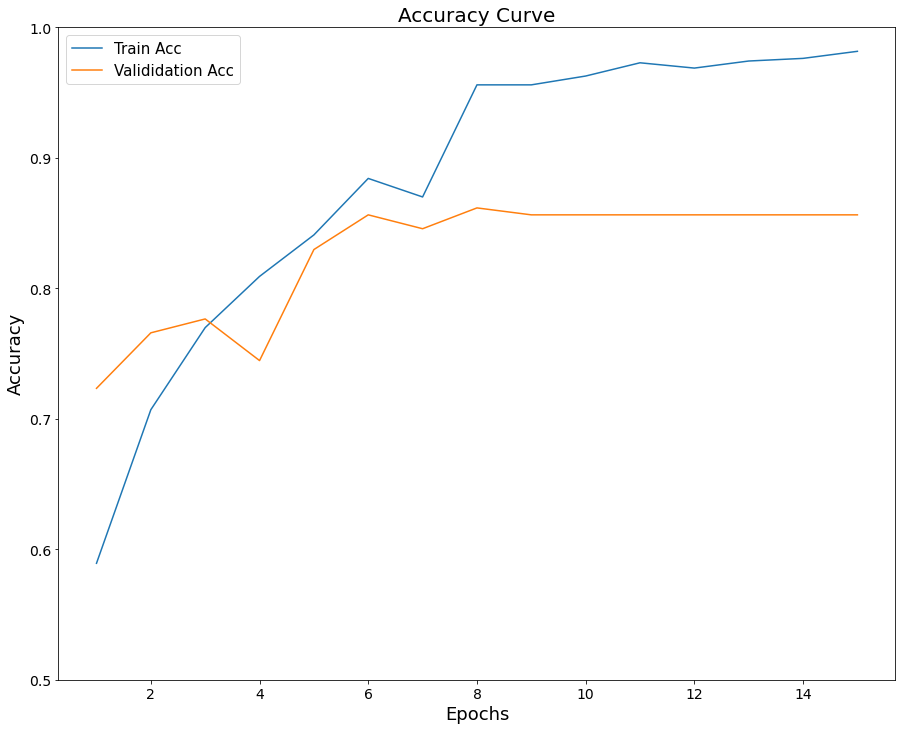

In [28]:
rl(util)
util.acc_curve(hist, savefig='class_acc')

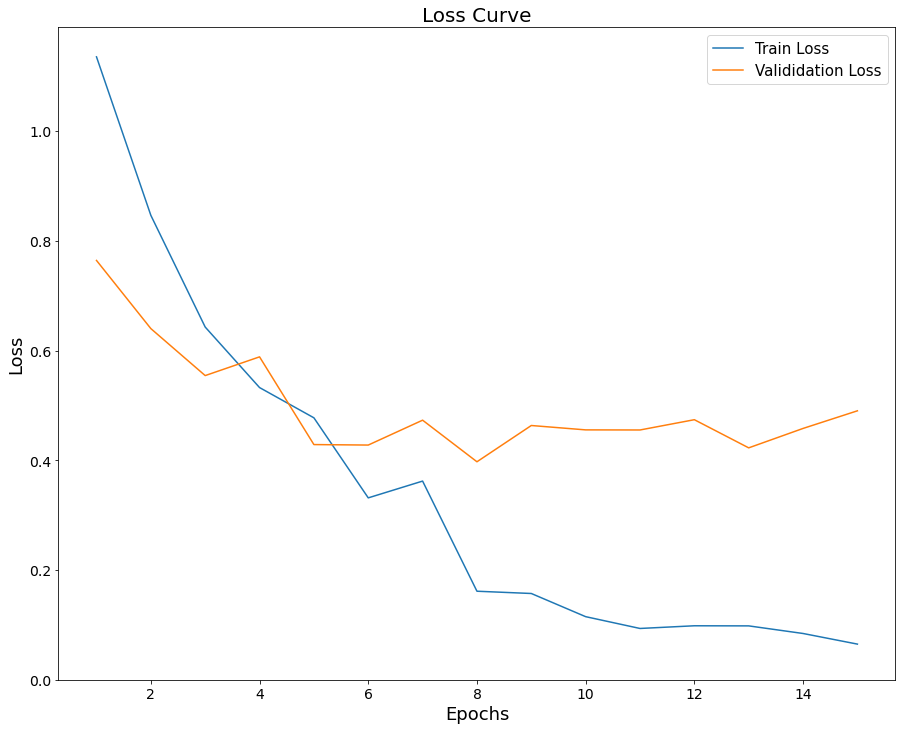

In [29]:
util.loss_curve(hist, savefig='class_loss')